In [1]:
import altair as alt
import json
import numpy as np
import pandas as pd

from itables import show
from pathlib import Path

DATA_DIR = Path("../data")

assert DATA_DIR.exists() and DATA_DIR.is_dir(), "Invalid path to data directory."

LANGS_2_MAPPING = {
    "en": "English",
    "ru": "Russian",
    "tr": "Turkish",
    "id": "Indonesian",
    "zh": "Chinese",
    "fa": "Persian",
    "ko": "Korean",
    "el": "Greek",
    "he": "Hebrew",
    "vi": "Vietnamese",
    "ja": "Japanese",
}

feats_df = pd.read_csv(DATA_DIR / "feature_values.csv", index_col=0)
p90_df = pd.read_csv(DATA_DIR / "p90_df.csv"
    ).set_index('Language'
    ).rename(columns=lambda x: x.split("_")[1])

# delta_df = pd.read_csv(DATA_DIR / "delta_df.csv"
#     ).set_index('Language'
#     ).rename(columns=lambda x: x.split("_")[1])
delta_df = pd.read_csv(DATA_DIR / "delta_df.csv")
df = pd.read_csv(DATA_DIR / "metrics_df.csv", index_col=0)
fit_df = pd.read_csv(DATA_DIR / "fit_data.csv", index_col=0)
POPT = json.load(open(DATA_DIR / "popt.json"))

delta_df

,Language,dev_Lemmas,dev_UPOS,dev_UAS,dev_LAS,dev_CLAS,dev_MLAS,dev_BLEX
0,English,7.237898,12.277060,24.856091,28.810041,33.045932,39.065684,35.036840
1,Russian,21.900942,17.311818,38.737058,43.298200,47.643670,54.956419,49.416457
2,Turkish,19.289765,9.965604,14.390629,22.831645,28.982843,31.678922,31.899510
3,Indonesian,4.495021,10.734945,28.895211,29.862494,31.980198,32.390382,31.343706
4,Chinese,0.111503,16.093663,41.209812,42.519978,43.808050,43.301435,43.822122
5,Persian,5.345527,7.702461,21.485811,25.502027,29.608043,35.057555,31.137986
6,Korean,5.003720,5.710565,11.653646,13.271949,14.864714,16.289945,15.855695
7,Greek,14.536053,12.142105,38.772383,40.208752,47.212099,52.678571,43.549563
8,Hebrew,10.406005,16.194700,44.228363,46.127602,47.848789,48.538012,44.444444
9,Vietnamese,1.078568,8.544863,20.994886,21.710832,23.045267,22.262047,23.164742


In [2]:
fit_df[fit_df['Language'] =='en']

,Checkpoint Step,Accuracy (normalized),Task,Language
0,0.000000,0.009578,dev_BLEX,en
1,0.081633,0.011900,dev_BLEX,en
2,0.163265,0.014776,dev_BLEX,en
3,0.244898,0.018334,dev_BLEX,en
4,0.326531,0.022729,dev_BLEX,en
...,...,...,...,...
45,3.673469,0.999165,dev_UPOS,en
46,3.755102,0.999375,dev_UPOS,en
47,3.836735,0.999533,dev_UPOS,en
48,3.918367,0.999651,dev_UPOS,en


In [3]:
def get_accuracy_chart(lang_df,  
                       title="", 
                       domain=[0,100],
                       width=150,
                       height=150):
    lang_df = lang_df.sort_values('Step')
    lang_df['Step'] = lang_df['Step'].astype(str)
    lang_df["Language"] = lang_df["Language"].map(LANGS_2_MAPPING)
    
    
    return alt.Chart(lang_df).mark_line(point=True).encode(
        x=alt.X(
            'Step', 
            sort=None, 
            axis=alt.Axis(
                title="Checkpoint Step",
                labelAngle=30
            )
        ),
        y=alt.Y('Accuracy', scale=alt.Scale(domain=domain)),
        color="Task",
        tooltip=['Language', 'Accuracy', 'Step', 'Tokens']
    ).properties(
        title=title,
        width=width,
        height=height
    )

In [4]:
def plot_best_fit_curve(data_points, 
                        fit_data, 
                        lang,
                        width=150, 
                        height=150):
    curve = alt.Chart(fit_data).mark_line(
    ).encode(
        x=alt.X(
            "Checkpoint Step:Q",
            sort=None,
            axis=alt.Axis(labels=True),
        ),
        y=alt.X(
            "Accuracy (normalized):Q",
            axis=alt.Axis(labels=False),
        ),
        color='Task:N'
    ).properties(
        width=width,
        height=height        
    )
    points = alt.Chart(data_points).mark_point(
        ).encode(
            x=alt.X(
                "N",
                sort=None,
                axis=alt.Axis(labels=True),
            ),
            y=alt.X(
                "Accuracy (normalized):Q"
            ),
            color="Task:N",
            tooltip=[
                "Task:N",
                "Accuracy",
                "Accuracy (normalized):Q",
                "Step:Q",
                "Tokens:N",
            ],
        ).properties(
            width=width,
            height=height        
        )
        
    chart = (curve + points).properties(
        title=LANGS_2_MAPPING[lang]
    )
    return chart


## Learning Curve Variation

### Language-Specific  

In [5]:
langs = ["ja", "en"]
h, w = 150, 200

def get_charts_for_langs(langs, 
                        df, 
                        fit_df, 
                        domain=[0,100],
                        height=150,
                        width=150):
    charts = []
    for lang in langs:
        charts.append(alt.hconcat(
                    get_accuracy_chart(
                        df[df['Language'] == lang],
                        title=LANGS_2_MAPPING[lang], 
                        domain=domain,
                        height=height,
                        width=width
                        ), 
                    plot_best_fit_curve(
                        df[df['Language'] == lang],
                        fit_df[fit_df['Language'] == lang],
                        lang,
                        height=height,
                        width=width
                        ),
                    )
                )
    return charts

charts = get_charts_for_langs(langs, df, fit_df, [30,100])
    
chart = alt.vconcat(*charts).properties(
    title=alt.Title(
        "Learning Curves for the Japanese and English Models", anchor="middle",
        offset=15)
    )
chart.show()

alt.VConcatChart(...)

### Task-Specific  

In [6]:
tasks = ["dev_Lemmas", "dev_UPOS", "dev_LAS", "dev_MLAS"]
height, width = 150, 150
charts = []
for task in tasks:
    filtered_df = df[df['Task'] == task].copy()
    filtered_df["Language"] = filtered_df["Language"].map(LANGS_2_MAPPING)
    filtered_fit_df = fit_df[fit_df['Task'] == task].copy()
    filtered_fit_df["Language"] = filtered_fit_df["Language"].map(LANGS_2_MAPPING)
    
    
    curve = alt.Chart(filtered_fit_df).mark_line(
    ).encode(
        x=alt.X(
            "Checkpoint Step:Q",
            sort=None,
            axis=alt.Axis(labels=True),
        ),
        y=alt.X(
            "Accuracy (normalized):Q",
            axis=alt.Axis(labels=False),
        ),
        color='Language:N'
    ).properties(
        width=width,
        height=height        
    )
    points = alt.Chart(filtered_df).mark_point(
        ).encode(
            x=alt.X(
                "N",
                sort=None,
                axis=alt.Axis(labels=True),
            ),
            y=alt.X(
                "Accuracy (normalized):Q"
            ),
            color="Language:N",
            tooltip=[
                "Language:N",
                "Task:N",
                "Accuracy",
                "Accuracy (normalized):Q",
                "Step:Q",
                "Tokens:N",
                
            ],
        ).properties(
            width=width,
            height=height        
        )
        
    chart = (curve + points).properties(
        title=task
    )
    charts.append(chart)

title="Learning Curve for All Languages on Selected Tasks"
alt.vconcat(
    alt.hconcat(*charts[:2]),
    alt.hconcat(*charts[2:],)
).properties(
    title=alt.Title(title, anchor="middle", offset=15)
).show()

alt.VConcatChart(...)

## Delta Variation

In [7]:
delta_df.columns[1:]

Index(['dev_Lemmas', 'dev_UPOS', 'dev_UAS', 'dev_LAS', 'dev_CLAS', 'dev_MLAS',
       'dev_BLEX'],
      dtype='object')

In [8]:
x_domain = [0,55]
for task in delta_df.columns[1:]:
    alt.Chart(delta_df).mark_bar().encode(
        x=alt.X(
            task, 
            title=f"{task} Delta",
            scale=alt.Scale(domain=x_domain)
        ),
        y='Language',
        color=alt.Color(
            'Language', 
            scale=alt.Scale(scheme="category20")
        ),
        tooltip=task
    ).show()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [9]:
tasks = ["dev_Lemmas", "dev_UPOS", "dev_LAS", "dev_MLAS"]
delta_df[['Language'] + tasks]

,Language,dev_Lemmas,dev_UPOS,dev_LAS,dev_MLAS
0,English,7.237898,12.277060,28.810041,39.065684
1,Russian,21.900942,17.311818,43.298200,54.956419
2,Turkish,19.289765,9.965604,22.831645,31.678922
3,Indonesian,4.495021,10.734945,29.862494,32.390382
4,Chinese,0.111503,16.093663,42.519978,43.301435
5,Persian,5.345527,7.702461,25.502027,35.057555
6,Korean,5.003720,5.710565,13.271949,16.289945
7,Greek,14.536053,12.142105,40.208752,52.678571
8,Hebrew,10.406005,16.194700,46.127602,48.538012
9,Vietnamese,1.078568,8.544863,21.710832,22.262047


In [10]:
x_domain = [0,55]
melted_df = delta_df[['Language'] + tasks].melt(id_vars='Language', 
              var_name='Task', 
              value_name='Delta'
            )
color_mapping = {'Chinese': '#1f77b4',
 'English': '#ff7f0e',
 'Greek': '#2ca02c',
 'Hebrew': '#d62728',
 'Indonesian': '#9467bd',
 'Japanese': '#8c564b',
 'Korean': '#e377c2',
 'Persian': '#7f7f7f',
 'Russian': '#bcbd22',
 'Turkish': '#17becf',
 'Vietnamese': '#d2b48c'}

y_domain = [0,55]
charts = []
for lang, _df in melted_df.groupby('Language'):
    charts.append(alt.Chart(_df).mark_bar(color=color_mapping[lang]).encode(
        x=alt.X(
            "Task:N", 
            sort=None, 
            axis=alt.Axis(labelAngle=-45, title=None)
        ),
        y=alt.Y(
            "Delta:Q", 
            scale=alt.Scale(domain=y_domain)
        ),
        tooltip=["Task:N", "Delta:Q", "Language:N"]
    ).properties(
        title=lang,
        height=150,
        width=100
    ))
    
alt.vconcat(
    *[alt.hconcat(*charts[i:i+4]) for i in range(0, len(charts), 4)]
).show()

alt.VConcatChart(...)

In [11]:
selected = charts[:2] + [charts[6]] + [charts[8]]

alt.hconcat(*selected)

alt.HConcatChart(...)

In [12]:
agglutinative = charts[4:8] + [charts[9]]
alt.hconcat(*agglutinative).show()

fusional = [charts[8],charts[2]]
alt.hconcat(*fusional).show()

analytic_1 = [charts[1], charts[3]]
alt.hconcat(*analytic_1).show()

analytic_2 = [charts[0], charts[10]]
alt.hconcat(*analytic_2).show()


alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

Agglutinative:

- Turkish
- Japanese
- Korean
- Persian
- Indonesian

Fusional:
- Russian
- Greek

Analytic:
- Chinese
- Vietnamese
- English (mostly, but some agglutinative morphology)

- Hebrew
    - incorporates analytic forms using prepositional particles; classical Hebrew used inflection
    - fusional: inflection plays a role in the formation of verbs and nouns and the declension of prepositions

In [28]:
melted_df['Agglutinative'] = [1 if x in ["Turkish","Japanese","Korean","Persian","Indonesian"] else 0 for x in melted_df['Language']]

melted_df = melted_df[melted_df['Task']!='dev_MLAS'].sort_values(by=['Task', 'Agglutinative', 'Language'])
melted_df

,Language,Task,Delta,Agglutinative
26,Chinese,dev_LAS,42.519978,0
22,English,dev_LAS,28.810041,0
29,Greek,dev_LAS,40.208752,0
30,Hebrew,dev_LAS,46.127602,0
23,Russian,dev_LAS,43.298200,0
31,Vietnamese,dev_LAS,21.710832,0
25,Indonesian,dev_LAS,29.862494,1
32,Japanese,dev_LAS,19.200816,1
28,Korean,dev_LAS,13.271949,1
27,Persian,dev_LAS,25.502027,1


In [43]:
y_domain = [0,55]
charts = []

alt.Chart(melted_df).mark_bar().encode(
    x=alt.X("Task:N", sort=None, axis=alt.Axis(labelAngle=0)),
    xOffset=alt.XOffset("Language:N", sort=None),
    y=alt.Y("Delta:Q"),
    color=alt.Color("Agglutinative:N"),
    tooltip=['Language', 'Agglutinative', 'Delta']
).properties(
    title={
        "text": "Potential Improvement on Selected Tasks",
        "subtitle": "Languages grouped by whether they are primarily agglutinative"
    },
    height=200,
    width=350
)

# for task, _df in melted_df.groupby('Language'):
#     charts.append(alt.Chart(_df).mark_bar(color=color_mapping[lang]).encode(
#         x=alt.X(
#             "Task:N", 
#             sort=None, 
#             axis=alt.Axis(labelAngle=-45, title=None)
#         ),
#         y=alt.Y(
#             "Delta:Q", 
#             scale=alt.Scale(domain=y_domain)
#         ),
#         tooltip=["Task:N", "Delta:Q", "Language:N"]
#     ).properties(
#         title=lang,
#         height=150,
#         width=100
#     ))
    
# alt.vconcat(
#     *[alt.hconcat(*charts[i:i+4]) for i in range(0, len(charts), 4)]
# ).show()

alt.Chart(...)

<Axes: xlabel='Task'>

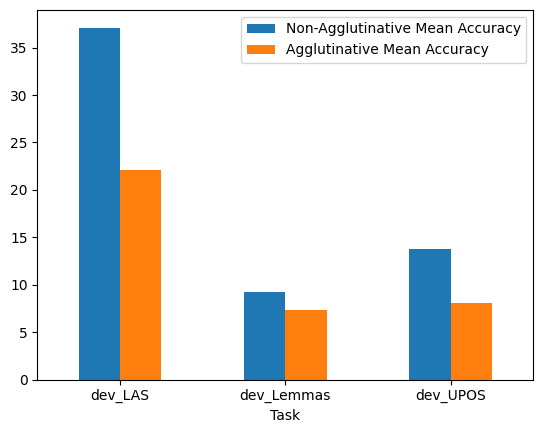

In [42]:
# Group by Task and Agglutinative, then calculate the mean of Accuracy
grouped_df = melted_df.groupby(['Task', 'Agglutinative']).agg({'Delta': 'mean'}).reset_index()

# Pivot the table to have Agglutinative values as columns
pivot_df = grouped_df.pivot(index='Task', columns='Agglutinative', values='Delta').reset_index()

# Rename columns for clarity
pivot_df.columns = ['Task', 'Non-Agglutinative Mean Accuracy', 'Agglutinative Mean Accuracy']

pivot_df.plot(kind="bar", x='Task', rot=0)

In [45]:
full_melted = delta_df.melt(id_vars='Language', 
              var_name='Task', 
              value_name='Delta'
            )
full_melted['Agglutinative'] = [1 if x in ["Turkish","Japanese","Korean","Persian","Indonesian"] else 0 for x in full_melted['Language']]

full_melted = full_melted.sort_values(by=['Task', 'Agglutinative', 'Language'])
full_melted

,Language,Task,Delta,Agglutinative
70,Chinese,dev_BLEX,43.822122,0
66,English,dev_BLEX,35.036840,0
73,Greek,dev_BLEX,43.549563,0
74,Hebrew,dev_BLEX,44.444444,0
67,Russian,dev_BLEX,49.416457,0
...,...,...,...,...
14,Indonesian,dev_UPOS,10.734945,1
21,Japanese,dev_UPOS,6.119043,1
17,Korean,dev_UPOS,5.710565,1
16,Persian,dev_UPOS,7.702461,1


Text(0, 0.5, 'Mean Delta')

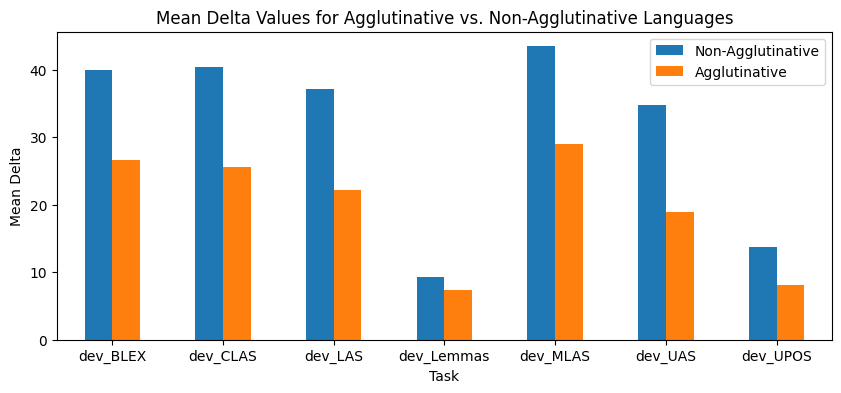

In [52]:
grouped_df = full_melted.groupby(
                            ['Task', 'Agglutinative']
                        ).agg(
                            {'Delta': 'mean'}
                        ).reset_index()

pivot_df = grouped_df.pivot(
                        index='Task', 
                        columns='Agglutinative', 
                        values='Delta'
                    ).reset_index()

# Rename columns for clarity
pivot_df.columns = ['Task', 'Non-Agglutinative', 'Agglutinative']

pivot_df.plot(kind="bar", 
              x='Task', 
              y=['Non-Agglutinative', 'Agglutinative'], 
              rot=0,
              figsize=(10, 4),
              title="Mean Delta Values for Agglutinative vs. Non-Agglutinative Languages"
            ).set_ylabel("Mean Delta")

Text(0, 0.5, 'Median Delta')

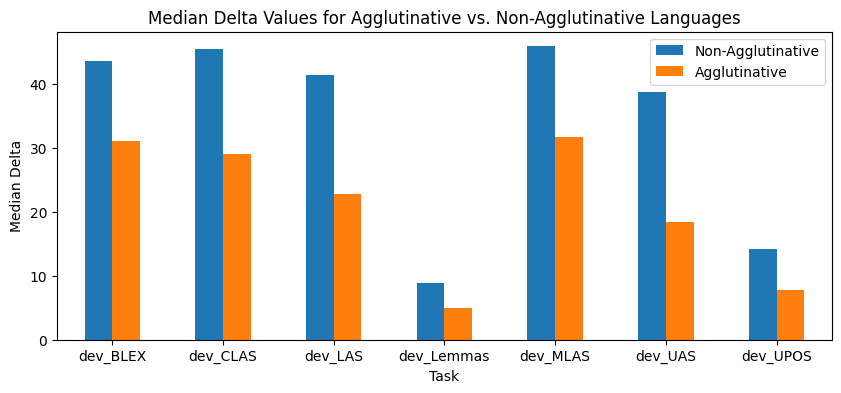

In [54]:
grouped_df = full_melted.groupby(
                            ['Task', 'Agglutinative']
                        ).agg(
                            {'Delta': 'median'}
                        ).reset_index()

pivot_df = grouped_df.pivot(
                        index='Task', 
                        columns='Agglutinative', 
                        values='Delta'
                    ).reset_index()

# Rename columns for clarity
pivot_df.columns = ['Task', 'Non-Agglutinative', 'Agglutinative']

pivot_df.plot(kind="bar", 
              x='Task', 
              y=['Non-Agglutinative', 'Agglutinative'], 
              rot=0,
              figsize=(10, 4),
              title="Median Delta Values for Agglutinative vs. Non-Agglutinative Languages"
            ).set_ylabel("Median Delta")


## Typological Correlations

In [57]:
from scipy.stats import pearsonr

for task, _df in full_melted.groupby("Task"):
    _corr = pearsonr(_df['Agglutinative'], _df['Delta'])
    if _corr.pvalue < 0.05:
        print(f"{task}\n\tCorr:{_corr.statistic}\n\tPvalue:{_corr.pvalue}")

dev_BLEX
	Corr:-0.6548122191754279
	Pvalue:0.028777014001410348
dev_CLAS
	Corr:-0.6763282807618568
	Pvalue:0.022311016794093853
dev_LAS
	Corr:-0.7038639148821668
	Pvalue:0.015634479491640825
dev_MLAS
	Corr:-0.6164088146945319
	Pvalue:0.04341561966531652
dev_UAS
	Corr:-0.7212894630029177
	Pvalue:0.012237168683903172
dev_UPOS
	Corr:-0.7340761820524717
	Pvalue:0.010109659241589068
